# Actividad 5.1. Clasificación de textos. Identificación de humor.

|||
|-|-|
|**Alumno**|Ángel García Alcántara<br><angelgarcan@gmail.com>|
|**Materia**|Recuperación de información<br>en Bases de datos no estructuradas<br>Cuarto Semestre|
|**Fecha**|20 de abril de 2020|

<br>
Implementar las diferentes estrategias de generación de centroides para los clasificadores Nearest Centroid así como las formas de pesado para el clasificador de vecinos cercanos. 

- Una vez implementados aplicar todas las versiones de los mismos al dataset HAHA 2019. Se deben reportar el desempeño. En la siguiente tabla se incluyen las métricas de desempeño a reportar para el clasificador incluido con FastText, así como para el Nerarest Centroid Average y $k$NN con pesado uniforme proporcionado en las palantillas.

------

*Tabla de desempeño para distintos clasificadores utilizando los vectores FastText
pre-entrenados para el idioma español*

------
|Clasificador|Accuracy|Macro F1|Macro Recall|F1 is_humor=1|
|:----------:|:------:|:------:|:----------:|:-----------:|
|FastText| 0.80905 | 0.79327|0.78690|0.73614|
|Nearest Centroid (Average)|0.76475 |0.76006|0.77290|0.72650|
|$k$NN (Pesado Uniforme)|0.79252|0.77397|0.76704|0.70922|
|Nearest Centroid (Rocchio)|
|Nearest Centroid (Suma)|
|Nearest Centroid (Suma normalizada)| 
|$k$NN (distancia mínima media)|  
|$k$NN (distancia pesada)| 

------
<br />

En su reporte deberá completar la tabla con los resultados para cada una de las variaciones de los alagoritmos propuestos. 

- Generar los una representación con pesado tfidf para el dataset HAHA 2019, posteriormente aplicar los clasificadores implementados a la representación generada. Incluir los resultados en forma de tabla. Justificar los resultados obtenidos en función de como son con los obtenidos sobre los vectores pre-entrenado

## Introducción

### Clasificación
La tarea de clasificación es un tarea de aprendizaje supervisado, 
la cual consiste en predecir una variable categórica, esto a partir 
de un conjunto de elementos ya categorizados. Por ejemplo:

- Definir si un correo electrónico es o no spam
- Si un paciente padece o no cierta enfermedad
- Análisis de polaridad en mensajes de twitter
- Detección de humor, determinar si un texto es o no un chiste 
- Si un objeto aparece o no en una imagen 

Todos los ejemplos mencionados pueden plantearse como: generar 
un mapeo o etiquetado de un conjunto de datos $X$ (tweets, 
documentos, imágenes, registros medicos) con respecto a un conjunto 
de categorías ( positivo/negativo/neutro, enfermo/sano, 
aparece una persona/no aparece una persona). El caso particular en 
que solo existen dos categorías se denomina clasificación binaria.

Dado que la clasificación es una técnica supervisada es necesario 
contar con el conjunto de datos $X$ así como con su conjunto de etiquetas 
$y$.  Donde  $X=\{x_1,...,x_n\}$  y cada elemento $x_i$ está definido en  $\mathbb{R}^m$ y $y=\{\theta_1 ,...,\theta_n\}$ donde  $\theta_i$ es la etiqueta correspondiente a cada $x_i$  y se define en $\{1,...,k\}$ para $k$  diferentes 
categorías.

### Nearest Centroid Classifier

Nearest Centroid (NC)  es un clasificador (también llamado Mean Difference Classifier) simple y poderoso. NC  es un claro ejemplo del  principio de suficiencia estadística, el cual nos dice que se pueden construir algoritmos a partir de resúmenes simples y significativos de los datos de entrenamiento. La forma más simple de resumir un conjunto de datos es mediate su media geométrica o centroide.  NC  como clasificador asigna a cada ejemplo desconocido la misma clase de su centroide más cercano.

Nearest Centroid en combinación con representaciones vectoriales ha sido ampliamente utilizado para la clasificación de documentos, cada centroide es visto como una sumarización de todos los documentos conocidos para una determinada clase. Dado el conjunto de vectores $X$ (generados mediante alguna técnica de vectorización) y etiquetas $y$ con valores  $C= \{1,...,𝑘\}$ para $k$ diferentes categorias (para el caso binario $C=\{0,1\}$). Para obterne un clasificador NC se deben generar un centroide por cada clase. 

Para continuar con la notación de clustering que utilizamos en la sección anterior tenemos que:  $G_i$ es el conjunto de documentos que perteneces a la iésima clase y $c_i$ el centroide del grupo $G_i$. Como ya vimos cada $c_i$ puede no ser siempre la media geométrica (recuerde podía ser la mediana o incluso un elemento del conjunto). En el caso de representaciones de texto existen muchas propuestas para el cálculo del *"centroide"* reportadas en la literatura. Algunas de las más básicas son:


- **Rocchio**, para este caso cada centroide $c_j$ es representado por la suma de todos los vectores de la clase $i$ menos la suma de aquellos vectores que no pertenecen a la clase $i$, se puede realizar un pesado mediante parámetros de control $\beta$ y $\gamma$ (usualmente $\beta=16$ y $\gamma=4$).

$$c_j= \beta \frac{1}{|G_j|} \sum_{x_i \in G_j} x_i- \gamma \frac{1}{|X|-|G_j|} \sum_{x_i \notin G_j} x_i$$

- El **promedio**, donde cada centroide es calculado cómo la media geométrica de cada grupo.

$$c_j=\frac{1}{|G_j|}\sum_{x_i \in G_j} x_i$$

- La **suma**, es similar al promedio solo sin dividir por la cardinalidad del grupo

$$c_j=\sum_{x_i \in G_j} x_i$$

- La **suma normalizada**, cada centroide $c_j$ es calculado como la suma de todos los vectores de la clase $j$ pero normalizados. 

$$c_j= \frac{1}{||\sum_{x_i \in G_j} x_i||}\sum_{x_i \in G_j} x_i$$

Como ya podrá haberse inferido las etapa de entrenamiento y el proceso de predicción de un clasificador NC es muy eficiente, ya que para aprender solo se debe calcular el centroide para cada clase y para la predicción sólo encontrar el centroide más similar para el ejemplo a predecir. Mientras que el entrenamiento es lineal(multiplicado por un factor del costo de la función de similitud), el proceso de predicción es constante ya que solo depende del número de clases y no del tamaño del conjunto de entrenamiento. 

### Clasificador $k$ Nearest Neighbor

El clasificador $k$ nearest neighbor ($k$NN), es un método no paramétrico que utiliza todos ejemplos en el conjunto de entrenamiento para predecir la clase de los ejemplos no etiquetados. Por lo que no hay fase de entrenamiento, la predicción se realiza mediante el uso de una función de similitud/distancia.

El clasificador $k$NN es simple e intuitivo, para $k=1$ funciona como sigue: dado un vector $x_q$, se le asocia la clase $\theta_q$ que será la misma que tenga el elemento más similar a $x_{nn} \in X$ más similar a $x_q$. El objeto $x_{nn}$ se determina como  $\arg\!\max_{1 \leq i \leq |X|} \cos (x_q, x_i)$ cuando se utiliza la similitud coseno o bien como $\arg\!\min_{1 \leq i \leq |X|} d(u, x_i)$  cuando se utiliza una función de distancia. Lo anterior da el origen al nombre desde que para determinar la clase de un objeto no etiquetado, primero debe encontrarse su vecino más cercano.  Una mejora directa es utilizar más de un vecino para calcular la clase de $x_q$, es decir utilizar $k>1$. Para $k>1$ se puede asignar a $x_q$ la clase que más se repita entre los $k$ vecinos más cercanos de $x_q$ (**pesado uniforme**).

|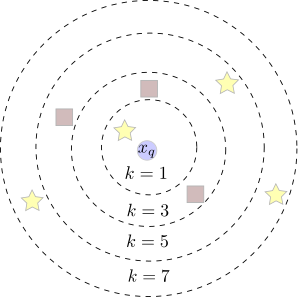|
|:--:|
|**Consulta $k$NN para diferentes valores de $k$**|

### Pesado de vecinos por distancia

También es común realizar un pesado de la contribución de cada vecino basados en el valor de la función de distancia o similitud. Para nuestro caso solo utilizaremos dos variantes simples. 

-  **$k$NN distancia/similitud media**: En este caso se asigna a  $x_q$ la clase en la que la distancia media de los $k$ vecinos seleccionados sea menor. Mientras que se utiliza el valor mayor cuando se utiliza una función de similitud.
- **$k$NN pesado por distancia**: Una forma básica de pesar cuando se utiliza una función de distancia es asignar a cada etiqueta un peso equivalente al inverso de la distancia. En el caso de la similitud puede ser el valor normalizado de la misma(cuando se usa coseno el valor ya está entre 0 y 1). Se asigna la clase que tenga el mayor peso.

Por ejemplo suponga que la información de cinco vecinos más cercanos para un $x_q$ dado en problema de 3 clases se resumen en la siguiente tabla. 

|&nbsp;|$x_1$|$x_2$|$x_3$|$x_4$|$x_5$|
|:------------:|:---:|:---:|:---:|:---:|:---:|
|Clase de $x_i$|  2  |  1  |  2  |  1  |  0  |
|$$d(x_i,x_q)$$| 0.5 | 0.2 |0.25 | 0.4 |0.125|
|$$w_{x_i}$$       |  2  |  5  |  4  | 2.5 |  8  |

en las siguiente tabla se muestra como se calculan los scores para cada clase

| <br /> | distancia media                    | pesado por distancia |uniforme|
|:------:|:---------------------------------: |:--------------:       |:----:|
|Clase 0 |  $d(x_5,x_q)/1$=**0.125**          |$w_{x_0}$=**8**            |   1  |
|Clase 1 |  $$(d(x_2,x_q)+d(x_4,x_q))/2=0.3$$   |$$w_{x_2}+w_{x_4}=7.5$$|   **2**  |
|Clase 2 |  $$(d(x_1,x_q)+d(x_3,x_q))/2=0.225$$ |$$w_{x_1}+w_{x_3}=6$$  |   **2**  |

usando la información en la tabla anterior podemos ver que para $k=5$, si se utiliza el criterio de la distancia mínimo promedio la clase para $x_q$ sería 0, al igual que para el pesado por distancia; mientras que para la decisión por mayoría de votos podría ser la clase 1 o 2. 

**Nota**: Si se utiliza una función de similitud no es necesario calcular el inverso, pero es buena idea normalizar.

In [1]:
# Multiple outputs per cell in Jupyter 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%javascript
// Evitar autoscroll.
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
from skeleton import *
from sklearn.metrics import (recall_score, f1_score,
                             precision_score, accuracy_score)
import gc

In [4]:
def testClassifier(clf,train,y_train,test,y_test):
    print("=== ",clf.__class__.__name__,end='')
    print(":",vars(clf))
    clf=clf.fit(train,y_train)
    #Predecimos las etiqueta del conjunto de prueba
    yp=clf.predict(test)
    # Medidas de bondad
    scores={}

    scores['Accuracy']=accuracy_score(y_test,yp)
    scores['Macro F1']=f1_score(y_test,yp,average='macro')
    scores['Macro Recall']=recall_score(y_test,yp,average='macro')
    scores['F1 is_humor=1']=f1_score(y_test,yp)
    
    print("Accuracy","Macro F1","Macro Recall","F1 is_humor=1",sep='\t')
    print("{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}".format(
        scores['Accuracy'],scores['Macro F1'],scores['Macro Recall'],scores['F1 is_humor=1']))
                            
#     print("Recall: ", scores['recall'])
#     print("F1: ", scores['f1'])
#     print("Accuracy: ", scores['accuracy'])
#     print("F1 Humor: ", scores['f1_humor'])
    #Vemos la frontera de decisión
    plotDecisionBoundary(clf,train, y_train)
    
    del(clf)
    del(yp)
    gc.collect()
    return scores

## Un problema de texto  (Identificación de humor HAHA -2019)

Para este ejemplo utilizaremos los datos proporcionados para la tarea 1 del HAHA - Humor Analysis based on Human Annotation, la cual consiste determinar si tweets en español son humorísticos o no (un problema de clasificación binaria). Esta tarea forma parte del Iberian Languages Evaluation Forum (IberLEF 2019).

### Corpus 

El conjunto de datos fue etiquetado como se indica [5]. Todos los tweets están etiquetados como humorístico **is_humor=1**  o no humorístico **is_humor=0**. Los datos relevantes para el problema se clasificación ser muestran en el siguiente ejemplo:

|Desscripción|Clave|Valor|
|:------:|:------:|:-----:|
|Tweet |text|Después de la tormenta sale... Tu mamá gritando porque no metiste la ropa.|
|Etiqueta de clase|is_humor|1|
|Representación vectorial|vec| Vectores de dimensión 300 (FastText preentrenados para español) |
|Identificador|id|942079817905770496|



In [ ]:
# Cargamos lod datos.
train_data=pd.read_json('data/haha_train_ft_pre.json',lines=True)

In [ ]:
#Vemos los primeros 5
train_data.head()[['id','text','is_humor','vec']]

In [ ]:
#Dimensión de los vectores
len(train_data.vec[3])

In [ ]:
# Los datos de prueba
test_data=pd.read_json('data/haha_test_ft_pre.json',lines=True)

In [ ]:
#Obtenemos la representación vectorial para los conjunto de prueba y entrenamiento
train,y_train=np.array([np.array(x) for x in train_data.vec]),np.array(train_data.is_humor)
test,y_test=np.array([np.array(x) for x in test_data.vec]),np.array(test_data.is_humor)

In [ ]:
P={"FastText":{"Accuracy":0.809050,"Macro F1":0.793270,"Macro Recall":0.786900,"F1 is_humor=1":0.736140}} #Performance

# # 
# P["NC.cos.avg"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Average'),train,y_train,test,y_test)
# P["NC.euc.avg"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Average'),train,y_train,test,y_test)

# P["NC.cos.sum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Sum'),train,y_train,test,y_test)
# P["NC.euc.sum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Sum'),train,y_train,test,y_test)

# P["NC.cos.rocchio"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Rocchio',beta=16,gamma=4),train,y_train,test,y_test)
# P["NC.euc.rocchio"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Rocchio',beta=16,gamma=4),train,y_train,test,y_test)

# P["NC.cos.nsum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='NormSum'),train,y_train,test,y_test)
# P["NC.euc.nsum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='NormSum'),train,y_train,test,y_test)


# P["KNN.cos.u"]=testClassifier(kNN(distance='coseno',k=5,weight_type='uniform'),train,y_train,test,y_test)
# P["KNN.euc.u"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='uniform'),train,y_train,test,y_test)

# P["KNN.cos.m"]=testClassifier(kNN(distance='coseno',k=5,weight_type='mean_dist'),train,y_train,test,y_test)
# P["KNN.euc.m"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='mean_dist'),train,y_train,test,y_test)

# P["KNN.cos.w"]=testClassifier(kNN(distance='coseno',k=5,weight_type='weighed_dist'),train,y_train,test,y_test)
# P["KNN.euc.w"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='weighed_dist'),train,y_train,test,y_test)

In [5]:
from toolbox import *

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
!rm -f *.pickle
!wc -l data/haha_*.json
# !cat data/haha_train_ft_pre_min10.json > data/haha_all_ft_pre_min10.json
# !cat data/haha_test_ft_pre_min10.json >> data/haha_all_ft_pre_min10.json
# !wc -l data/haha_all_ft_pre_min10.json
!cat data/haha_train_ft_pre.json > data/haha_all_ft_pre.json
!cat data/haha_test_ft_pre.json >> data/haha_all_ft_pre.json
!wc -l data/haha_all_ft_pre.json

!rm -f *.pickle
inv_idx = InvertedIdx("data/haha_all_ft_pre.json")
inv_idx.process(showProgressEach=5000)
inv_idx.compute_mtx()
tfidf=pd.DataFrame(inv_idx.idx_mtx.todense(), index=inv_idx.corpus).T
tfidf

    24000 data/haha_all_ft_pre.json
      240 data/haha_all_ft_pre_min10.json
     7201 data/haha_test_ft_pre.json
       72 data/haha_test_ft_pre_min10.json
    16799 data/haha_train_ft_pre.json
      168 data/haha_train_ft_pre_min10.json
    48480 total
24000 data/haha_all_ft_pre.json
** Processing data/haha_all_ft_pre.json ...
2020-05-09 07:16:46.836535 :: 0.00067 - Processing item #0 
2020-05-09 07:16:50.767365 :: 3.9315 - Processing item #5000 
2020-05-09 07:16:54.660858 :: 7.824993 - Processing item #10000 
2020-05-09 07:16:59.074286 :: 12.238421 - Processing item #15000 
2020-05-09 07:17:03.038350 :: 16.202485 - Processing item #20000 
** Processed 24000 lines. Saved to /home/jovyan/public/B5_Clasificacion/tokenized_docs.pickle.
** Computing TF-IDF...
** Computed TF-IDF Matrix !!!
** Done poda0 TF-IDF Matrix !!!
poda0_mtx.pickle written.


<16447x24000 sparse matrix of type '<class 'numpy.float16'>'
	with 165547 stored elements in List of Lists format>

,aa,aabort,aacaca,aagg,aaghh,aah,aahh,aajajfkajd,aam,aamhigh,...,zuli,zulu,zum,zumb,zup,zuperm,zurr,zuv,zz,zzi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_n=len(train_data)
test_n=len(test_data)
train_n,test_n # (16799, 7201)

In [7]:
del(inv_idx)
# del(train_data)
# del(test_data)
gc.collect()

20

In [8]:
test2=np.array([np.array(row) for _, row in tfidf.tail(7201).iterrows()])

In [9]:
train2=np.array([np.array(row) for _, row in tfidf.head(16799).iterrows()])

In [10]:
del(tfidf)
gc.collect()

60

In [11]:
# Cargamos lod datos.
train_data=pd.read_json('data/haha_train_ft_pre.json',lines=True)
#Obtenemos la representación vectorial para los conjunto de prueba y entrenamiento
y_train=np.array(train_data.is_humor)
# Los datos de prueba
test_data=pd.read_json('data/haha_test_ft_pre.json',lines=True)
y_test=np.array(test_data.is_humor)

del(train_data)
del(test_data)
gc.collect()

0

In [ ]:
# train2=np.array(tfidf.head(train_n))
# test2=np.array(tfidf.tail(test_n))
# train2.shape,test2.shape

In [ ]:
# train2=np.ascontiguousarray(tfidf.head(train_n).to_numpy())
# test2=np.ascontiguousarray(tfidf.tail(test_n).to_numpy())
# train2.shape,test2.shape

In [ ]:
P2={} #Performance

# 
P2["NC.cos.avg"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Average'),train2,y_train,test2,y_test)
P2["NC.euc.avg"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Average'),train2,y_train,test2,y_test)

P2["NC.cos.sum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Sum'),train2,y_train,test2,y_test)
P2["NC.euc.sum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Sum'),train2,y_train,test2,y_test)

P2["NC.cos.rocchio"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Rocchio',beta=16,gamma=4),train2,y_train,test2,y_test)
P2["NC.euc.rocchio"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Rocchio',beta=16,gamma=4),train2,y_train,test2,y_test)

P2["NC.cos.nsum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='NormSum'),train2,y_train,test2,y_test)
P2["NC.euc.nsum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='NormSum'),train2,y_train,test2,y_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


===  NearestCentroid: {'distance': <function coseno at 0x7f449e9f55f0>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7f449a2090d0>>, 'kwargs_': {}}


/home/jovyan/public/B5_Clasificacion/skeleton.py:18: RuntimeWarning: invalid value encountered in float_scalars
  dist=1-np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.706569	0.692960	0.694606	0.628320


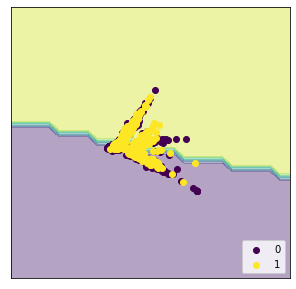

===  NearestCentroid: {'distance': <function euclidiana at 0x7f44a0fe5dd0>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7f44c0432c10>>, 'kwargs_': {}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.718511	0.695084	0.691221	0.610567


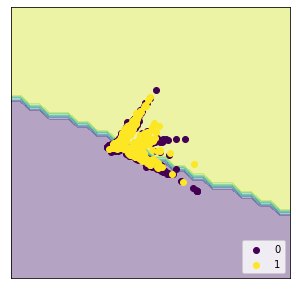

===  NearestCentroid: {'distance': <function coseno at 0x7f449e9f55f0>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7f449e91ec10>>, 'kwargs_': {}}


/home/jovyan/public/B5_Clasificacion/skeleton.py:18: RuntimeWarning: invalid value encountered in half_scalars
  dist=1-np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.613665	0.380293	0.500000	0.000000


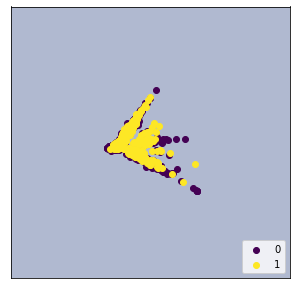

===  NearestCentroid: {'distance': <function euclidiana at 0x7f44a0fe5dd0>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7f44a36bbd90>>, 'kwargs_': {}}


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.613665	0.380293	0.500000	0.000000


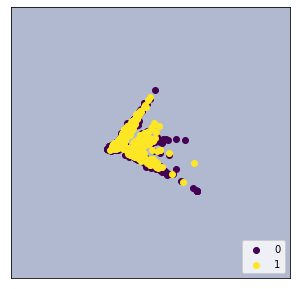

===  NearestCentroid: {'distance': <function coseno at 0x7f449e9f55f0>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7f449ecc3110>>, 'kwargs_': {'beta': 16, 'gamma': 4}}


/home/jovyan/public/B5_Clasificacion/skeleton.py:18: RuntimeWarning: invalid value encountered in float_scalars
  dist=1-np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.707124	0.692311	0.693061	0.624800


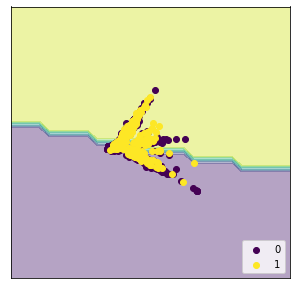

===  NearestCentroid: {'distance': <function euclidiana at 0x7f44a0fe5dd0>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7f449eb42d50>>, 'kwargs_': {'beta': 16, 'gamma': 4}}
Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.613665	0.380293	0.500000	0.000000


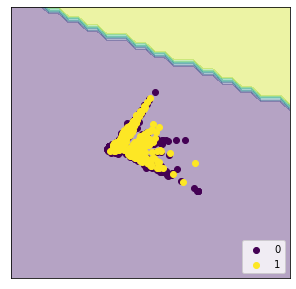

===  NearestCentroid: {'distance': <function coseno at 0x7f449e9f55f0>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7f449a21ced0>>, 'kwargs_': {}}


/home/jovyan/public/B5_Clasificacion/skeleton.py:18: RuntimeWarning: invalid value encountered in half_scalars
  dist=1-np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


Accuracy	Macro F1	Macro Recall	F1 is_humor=1
0.613665	0.380293	0.500000	0.000000


/home/jovyan/public/B5_Clasificacion/skeleton.py:18: RuntimeWarning: invalid value encountered in double_scalars
  dist=1-np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


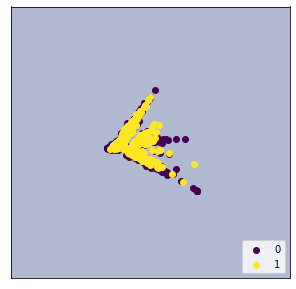

===  NearestCentroid: {'distance': <function euclidiana at 0x7f44a0fe5dd0>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7f449e91ec10>>, 'kwargs_': {}}


In [ ]:
P2["KNN.cos.u"]=testClassifier(kNN(distance='coseno',k=5,weight_type='uniform'),train2,y_train,test2,y_test)
P2["KNN.euc.u"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='uniform'),train2,y_train,test2,y_test)

P2["KNN.cos.m"]=testClassifier(kNN(distance='coseno',k=5,weight_type='mean_dist'),train2,y_train,test2,y_test)
P2["KNN.euc.m"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='mean_dist'),train2,y_train,test2,y_test)

P2["KNN.cos.w"]=testClassifier(kNN(distance='coseno',k=5,weight_type='weighed_dist'),train2,y_train,test2,y_test)
P2["KNN.euc.w"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='weighed_dist'),train2,y_train,test2,y_test)

In [ ]:
gc.collect()

In [ ]:
df=pd.DataFrame(P).T.sort_values("F1 is_humor=1",ascending =False)
df

In [ ]:
df2=pd.DataFrame(P2).T.sort_values("F1 is_humor=1",ascending =False)
df2

In [ ]:
df.describe()

In [ ]:
df2.describe()